In [1]:
import qiskit.tools.jupyter

%qiskit_version_table


# The new Qiskit 

Notice that you'll need latest development version of the `qiskit_machine_learning` to proceed. Please follow the instructions [here](https://qiskit.org/ecosystem/machine-learning/getting_started.html#installation) to install the library from source in your Conda environment. This will also install a newer version of Qiskit where the new `primitives`, in combination with the `quantum_info` module, have superseded functionality of opflow. Thus, the latter is being deprecated.

## Primitives

[Primitives](https://qiskit.org/ecosystem/ibm-runtime/primitives.html) are core functions that make it easier to build modular algorithms and applications.

The initial release of Qiskit Runtime includes two primitives:

**Sampler**: Generates quasi-probability distribution from input circuits.

**Estimator**: Calculates expectation values from input circuits and observables.

## Using the Estimator primitive

Similar to the `Backend` base class, there is an `Estimator` base class defined in Qiskit Terra that standardizes the way users interact with all `Estimator` implementations. This allows users to easily change their choice of simulator or device for performing expectation value calculations, even if the underlying implementation is different.

In this section we will be using the default implementation in Qiskit Terra, which uses a local state vector simulator.

### 1. Create a circuit

For a basic expectation value calculation you will need at least one quantum circuit to prepare our system in a precise quantum state for study. Here, `Decompose` is a "shallow" unroller, it unrolls every instruction one level down (so that you end up with a more readable circuit).  


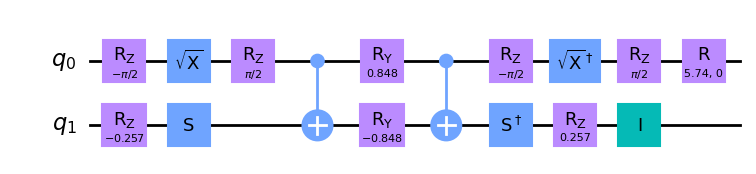

In [2]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(circuit.draw("mpl"))

### 2. Create an observable to measure

You will also need at least one observable to measure. Observables represent physical properties of a quantum system (such as energy or spin), and allow said properties to be measured (such as their expectation values) for a given state of our system. For simplicity, you can use the SparsePauliOp class in Qiskit to define them. 

In [3]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("XZ")
print(f">>> Observable: {observable.paulis}")

>>> Observable: ['XZ']


### 3. Initialize an Estimator class

The next step is to create an instance of an `Estimator` class, which can be any of the subclasses that comply with the base specification. For simplicity, we will use Qiskit Terra's  `qiskit.primitives.Estimator` class, based on the [Statevector construct](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html?highlight=statevector#qiskit.quantum_info.Statevector) (algebraic simulation).

In [4]:
from qiskit.primitives import Estimator

estimator = Estimator()

### 4. Invoke the Estimator and get results

To calculate the expectation values, invoke the `run()` method of the `Estimator` instance you just created and pass in the circuit and observable as input parameters. This method call is asynchronous, and you will get a `Job` object back. You can use this object to query for information like `job_id()` and `status()`  

In [5]:
job = estimator.run(circuit, observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: f934565a-5c70-4da8-b32f-9173b06c10fb
>>> Job Status: JobStatus.RUNNING


The `result()` method of the job will return the `EstimatorResult`, which includes both the expectation values and job metadata.

In [6]:
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")

>>> EstimatorResult(values=array([0.50006466]), metadata=[{}])
  > Expectation value: 0.5000646622430736


### Do it yourself

Create a random circuit to prepare a state, create an observable, invoke `run()` method to  get expectation value

In [ ]:
### Code me

### Do it yourself

The `RealAmplitudes` circuit is a heuristic trial wave function used as Ansatz in chemistry applications or classification circuits in machine learning. The circuit consists of alternating layers of $Y$ rotations and $CX$ entanglements. The entanglement pattern can be user-defined or selected from a predefined set (hence it is parametric). It is called `RealAmplitudes` since the prepared quantum states will only have real amplitudes, the complex part is always 0.

Use this parametrized circuit and an observable


In [ ]:
from qiskit.circuit.library import RealAmplitudes

circuit = RealAmplitudes(num_qubits=2, reps=2).decompose(reps=1)
observable = ## code me 
parameter_values = []## code me 

job = ## code me
result = job.result()

display(circuit.draw("mpl"))
print(f">>> Observable: {observable.paulis}")
print(f">>> Parameter values: {parameter_values}")
print(f">>> Expectation value: {result.values[0]}")

# Quantum Neural Networks


## 1. Introduction

### 1.1. Quantum vs. Classical Neural Networks

Classical neural networks are algorithmic models inspired by the human brain that can be trained to recognize patterns in data and learn to solve complex problems. They are based on a series of interconnected nodes, or *neurons*, organized in a layered structure, with parameters that can be learned by applying machine or deep learning training strategies.

The motivation behind quantum machine learning (QML) is to integrate notions from quantum computing and classical machine learning to open the way for new and improved learning schemes. QNNs apply this generic principle by combining classical neural networks and parametrized quantum circuits. Because they lie at an intersection between two fields, QNNs can be viewed from two perspectives:

- From a **machine learning perspective**, QNNs are, once again, algorithmic models that can be trained to find hidden patterns in data in a similar manner to their classical counterparts. These models can **load** classical data (**inputs**) into a quantum state, and later **process** it with quantum gates parametrized by **trainable weights**. Figure 1 shows a generic QNN example including the data loading and processing steps. The output from measuring this state can then be plugged into a loss function to train the weights through backpropagation.

- From a **quantum computing perspective**, QNNs are quantum algorithms based on parametrized quantum circuits that can be trained in a variational manner using classical optimizers. These circuits contain a **feature map** (with input parameters) and an **ansatz** (with trainable weights), as seen in Figure 1.

![new_qnn-3.jpg](new_qnn-3.jpg)


*Figure 1. Generic quantum neural network (QNN) structure.*
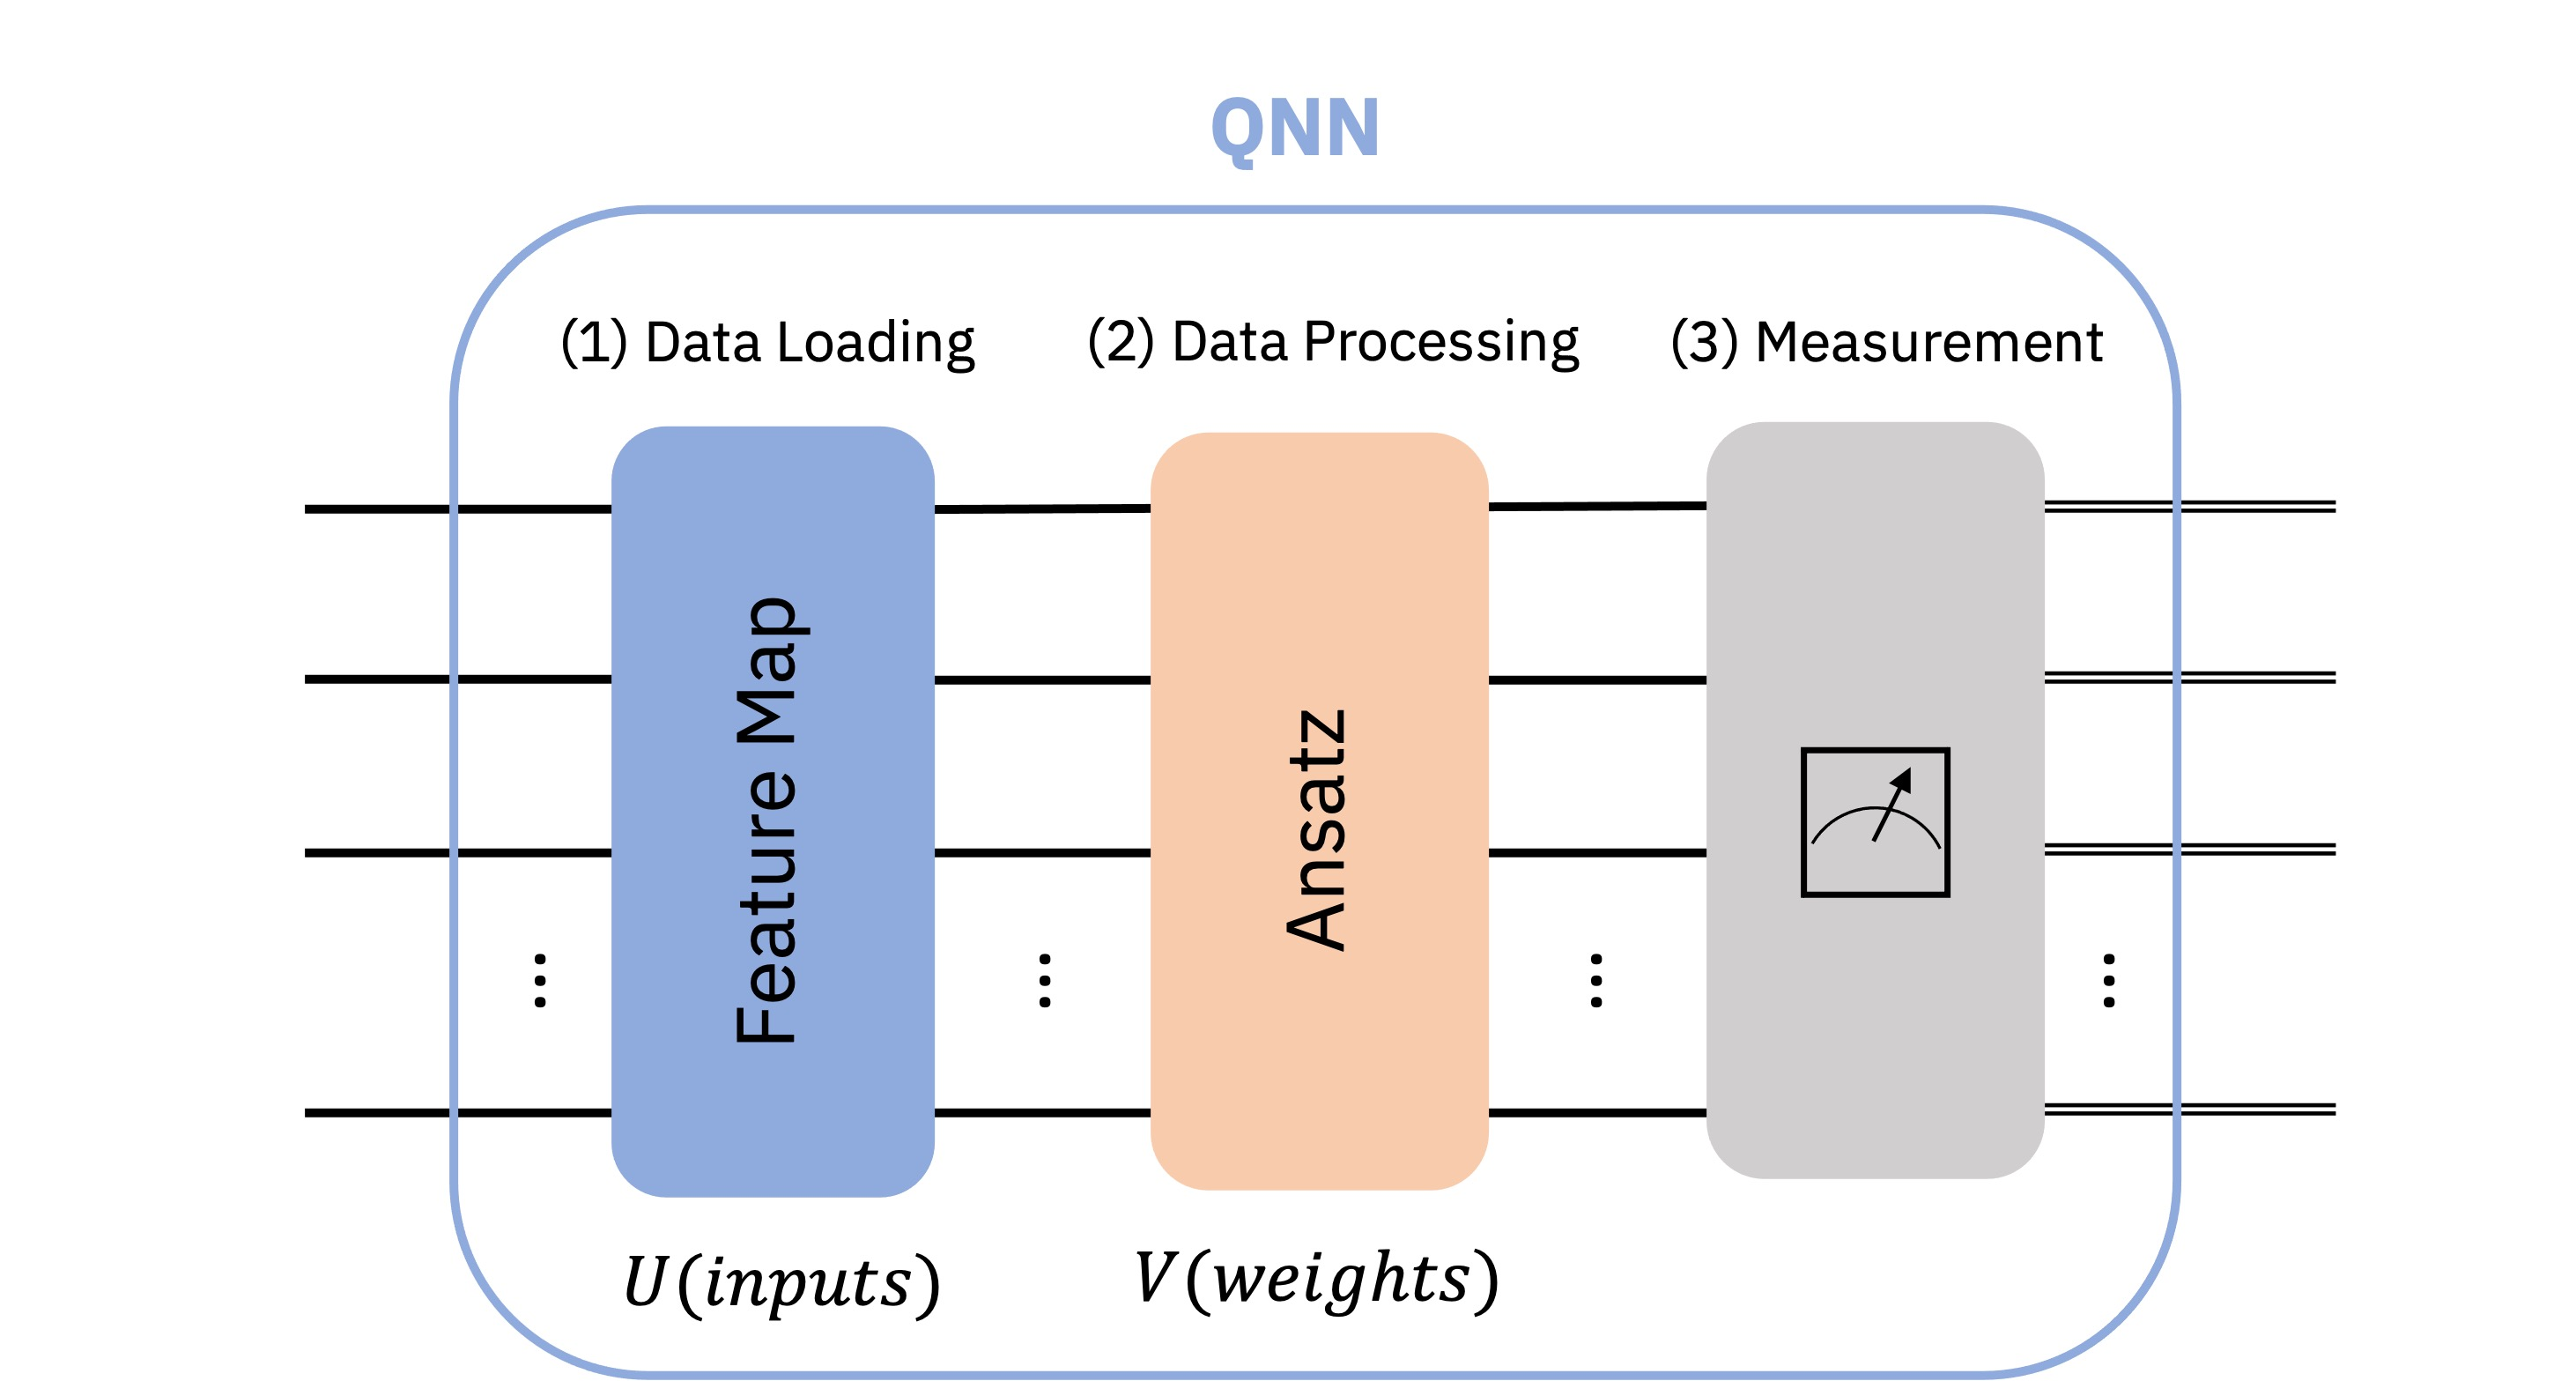

As you can see, these two perspectives are complementary, and do not necessarily rely on strict definitions of concepts such as "quantum neuron" or what constitutes a QNN's "layer".

### 1.2. Implementation in `qiskit-machine-learning`

The QNNs in `qiskit-machine-learning` are meant as application-agnostic computational units that can be used for different use cases, and their setup will depend on the application they are needed for. The module contains an interface for the QNNs and two specific implementations:

1. [NeuralNetwork](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.NeuralNetwork.html): The interface for neural networks. This is an abstract class all QNNs inherit from.
2. [EstimatorQNN](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html): A network based on the evaluation of quantum mechanical observables.
3. [SamplerQNN](https://qiskit.org/ecosystem/machine-learning/locale/fr_FR/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html): A network based on the samples resulting from measuring a quantum circuit.


These implementations are based on the [qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html). The primitives are the entry point to run QNNs on either a simulator or real quantum hardware. Each implementation, `EstimatorQNN` and `SamplerQNN`, takes in an optional instance of its corresponding primitive, which can be any subclass of `BaseEstimator` and `BaseSampler`, respectively.


The `NeuralNetwork` class is the interface for all QNNs available in `qiskit-machine-learning`.
It exposes a forward and a backward pass that take data samples and trainable weights as input.

It's important to note that `NeuralNetwork`s are "stateless". They do not contain any training capabilities (these are pushed to the actual algorithms or applications: [classifiers](https://qiskit.org/ecosystem/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#classifiers), [regressors](https://qiskit.org/ecosystem/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#regressors), etc), nor do they store the values for trainable weights.

***

Let's now look into specific examples for the two `NeuralNetwork` implementations. But first, let's set the algorithmic seed to ensure that the results don't change between runs.

In [7]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 42

## 2. How to Instantiate QNNs

### 2.1. `EstimatorQNN`

The `EstimatorQNN` takes in a parametrized quantum circuit as input, as well as an optional quantum mechanical observable, and outputs expectation value computations for the forward pass. The `EstimatorQNN` also accepts lists of observables to construct more complex QNNs.

Let's see an `EstimatorQNN` in action with a simple example. We start by constructing the parametrized circuit. This quantum circuit has two parameters, one represents a QNN input and the other represents a trainable weight:

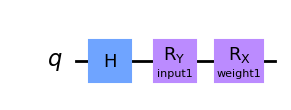

In [8]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl")

We can now create an observable to define the expectation value computation. If not set, then the `EstimatorQNN` will automatically create the default observable $Z^{\otimes n}$. Here, $n$ is the number of qubits of the quantum circuit.

In this example, we will change things up and use the $Y^{\otimes n}$ observable:

In [9]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

Together with the quantum circuit defined above, and the observable we have created, the `EstimatorQNN` constructor takes in the following keyword arguments:

- `estimator`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

In this example, we previously decided that the first parameter of `params1` should be the input, while the second should be the weight. As we are performing a local statevector simulation, we will not set the `estimator` parameter; the network will create an instance of the reference `Estimator` primitive for us. If we needed to access cloud resources or `Aer` simulators, we would have to define the respective `Estimator` instances and pass them to the `EstimatorQNN`.

In [10]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn

We'll see how to use the QNN in the following sections, but before that, let's check out the `SamplerQNN` class.

### 2.2. `SamplerQNN`

The `SamplerQNN` is instantiated in a similar way to the `EstimatorQNN`, but because it directly consumes samples from measuring the quantum circuit, it does not require a custom observable.

These output samples are interpreted by default as the probabilities of measuring the integer index corresponding to a bitstring. However, the `SamplerQNN` also allows us to specify an `interpret` function to post-process the samples. This function should be defined so that it takes a measured integer (from a bitstring) and maps it to a new value, i.e. non-negative integer.

**(!)** It's important to note that if a custom `interpret` function is defined, the `output_shape` cannot be inferred by the network, and **needs to be provided explicitly**.

**(!)** It's also important to keep in mind that if no `interpret` function is used, the dimension of the probability vector will scale exponentially with the number of qubits. With a custom `interpret` function, this scaling can change. If, for instance, an index is mapped to the parity of the corresponding bitstring, i.e., to 0 or 1, the result will be a probability vector of length 2 independently of the number of qubits.

Let's create a different quantum circuit for the `SamplerQNN`. In this case, we will have two input parameters and four trainable weights that parametrize a  two-local circuit.

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


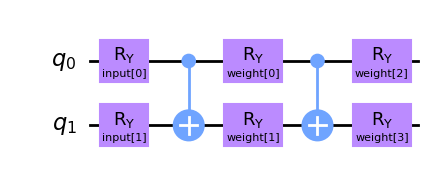

In [11]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")

Similarly to the `EstimatorQNN`, we must specify inputs and weights when instantiating the `SamplerQNN`. In this case, the keyword arguments will be:
- `sampler`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

Please note that, once again, we are choosing not to set the `Sampler` instance to the QNN and relying on the default.

In [12]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs2, weight_params=weights2)
sampler_qnn

In addition to the basic arguments shown above, the `SamplerQNN` accepts three more settings: `input_gradients`, `interpret`, and `output_shape`. These will be introduced in sections 4 and 5.

## 3. How to Run a Forward Pass

The "forward pass" refers to calculation process, values of the output layers from the inputs data. It's traversing through all "neurons" from first to last layer. A loss function is calculated from the output values.



### 3.1. Set-Up
In a real setting, the inputs would be defined by the dataset, and the weights would be defined by the training algorithm or as part of a pre-trained model. However, for the sake of this tutorial, we will specify random sets of input and weights of the right dimension:

#### 3.1.1. `EstimatorQNN` Example

In [13]:
estimator_qnn_input = algorithm_globals.random.random(estimator_qnn.num_inputs)
estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)

In [14]:
print(
    f"Number of input features for EstimatorQNN: {estimator_qnn.num_inputs} \nInput: {estimator_qnn_input}"
)
print(
    f"Number of trainable weights for EstimatorQNN: {estimator_qnn.num_weights} \nWeights: {estimator_qnn_weights}"
)

Number of input features for EstimatorQNN: 1 
Input: [0.77395605]
Number of trainable weights for EstimatorQNN: 1 
Weights: [0.43887844]


#### 3.1.2. `SamplerQNN` Example

In [15]:
sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

In [16]:
print(
    f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {sampler_qnn_input}"
)
print(
    f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {sampler_qnn_weights}"
)

Number of input features for SamplerQNN: 2 
Input: [0.85859792 0.69736803]
Number of trainable weights for SamplerQNN: 4 
Weights: [0.09417735 0.97562235 0.7611397  0.78606431]


Once we have the inputs and the weights, let's see the results for batched and non-batched passes.

### 3.2. Non-batched Forward Pass

#### 3.2.1. `EstimatorQNN` Example

For the `EstimatorQNN`, the expected output shape for the forward pass is `(1, num_qubits * num_observables)` where `1` in our case is the number of samples:

In [17]:
estimator_qnn_forward = estimator_qnn.forward(estimator_qnn_input, estimator_qnn_weights)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward}. \nShape: {estimator_qnn_forward.shape}"
)

Forward pass result for EstimatorQNN: [[0.2970094]]. 
Shape: (1, 1)


#### 3.2.2. `SamplerQNN` Example

For the `SamplerQNN` (without a custom interpret function), the expected output shape for the forward pass is `(1, 2**num_qubits)`. With a custom interpret function, the output shape will be `(1, output_shape)`, where `1` in our case is the number of samples:

In [18]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.  \nShape: {sampler_qnn_forward.shape}"
)

Forward pass result for SamplerQNN: [[0.01826527 0.25735654 0.5267981  0.19758009]].  
Shape: (1, 4)


### 3.3. Batched Forward Pass

#### 3.3.1. `EstimatorQNN` Example

For the `EstimatorQNN`, the expected output shape for the forward pass is `(batch_size, num_qubits * num_observables)`:

In [19]:
estimator_qnn_forward_batched = estimator_qnn.forward(
    [estimator_qnn_input, estimator_qnn_input], estimator_qnn_weights
)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward_batched}.  \nShape: {estimator_qnn_forward_batched.shape}"
)

Forward pass result for EstimatorQNN: [[0.2970094]
 [0.2970094]].  
Shape: (2, 1)


#### 3.3.2. `SamplerQNN` Example

For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits)`. With a custom interpret function, the output shape will be `(batch_size, output_shape)`.

In [20]:
sampler_qnn_forward_batched = sampler_qnn.forward(
    [sampler_qnn_input, sampler_qnn_input], sampler_qnn_weights
)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward_batched}.  \nShape: {sampler_qnn_forward_batched.shape}"
)

Forward pass result for SamplerQNN: [[0.01826527 0.25735654 0.5267981  0.19758009]
 [0.01826527 0.25735654 0.5267981  0.19758009]].  
Shape: (2, 4)


## 4. How to Run a Backward Pass

"Backward pass" refers to process of counting changes in weights (de facto learning), using gradient descent algorithm (or similar). Computation is made from last layer, backward to the first layer.

Backward and forward pass makes together one "iteration".

Let's take advantage of the inputs and weights defined above to show how the backward pass works. This pass returns a tuple `(input_gradients, weight_gradients)`. By default, the backward pass will only calculate gradients with respect to the weight parameters.

If you want to enable gradients with respect to the input parameters, you should set the following flag during the QNN instantiation:

```
qnn = ... QNN(..., input_gradients=True)
```

Please remember that input gradients are **required** for the use of `TorchConnector` for PyTorch integration.

### 4.1. Backward Pass without Input Gradients

#### 4.1.1. `EstimatorQNN` Example

For the `EstimatorQNN`, the expected output shape for the weight gradients is `(batch_size, num_qubits * num_observables, num_weights)`:

In [21]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(
    f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad}"
)
print(
    f"Weight gradients for EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}"
)

Input gradients for EstimatorQNN: None.  
Shape: None
Weight gradients for EstimatorQNN: [[[0.63272767]]].  
Shape: (1, 1, 1)


#### 4.1.2. `SamplerQNN` Example

For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits, num_weights)`. With a custom interpret function, the output shape will be `(batch_size, output_shape, num_weights)`.:

In [22]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: None.  
Shape: None
Weight gradients for SamplerQNN: [[[ 0.00606238 -0.1124595  -0.06856156 -0.09809236]
  [ 0.21167414 -0.09069775  0.06856156 -0.22549618]
  [-0.48846674  0.32499215 -0.32262178  0.09809236]
  [ 0.27073021 -0.12183491  0.32262178  0.22549618]]].  
Shape: (1, 4, 4)


### 4.2. Backward Pass with Input Gradients

Let's enable the `input_gradients` to show what the expected output sizes are for this option.

In [23]:
estimator_qnn.input_gradients = True
sampler_qnn.input_gradients = True

#### 4.2.1. `EstimatorQNN` Example

For the `EstimatorQNN`, the expected output shape for the input gradients is `(batch_size, num_qubits * num_observables, num_inputs)`:

In [24]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(
    f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad.shape}"
)
print(
    f"Weight gradients for EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}"
)

Input gradients for EstimatorQNN: [[[0.3038852]]].  
Shape: (1, 1, 1)
Weight gradients for EstimatorQNN: [[[0.63272767]]].  
Shape: (1, 1, 1)


#### 4.2.2. `SamplerQNN` Example

For the `SamplerQNN` (without custom interpret function), the expected output shape for the input gradients is `(batch_size, 2**num_qubits, num_inputs)`. With a custom interpret function, the output shape will be `(batch_size, output_shape, num_inputs)`.

In [25]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad.shape}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: [[[-0.05844702 -0.10621091]
  [ 0.38798796 -0.19544083]
  [-0.34561132  0.09459601]
  [ 0.01607038  0.20705573]]].  
Shape: (1, 4, 2)
Weight gradients for SamplerQNN: [[[ 0.00606238 -0.1124595  -0.06856156 -0.09809236]
  [ 0.21167414 -0.09069775  0.06856156 -0.22549618]
  [-0.48846674  0.32499215 -0.32262178  0.09809236]
  [ 0.27073021 -0.12183491  0.32262178  0.22549618]]].  
Shape: (1, 4, 4)


## 5. Advanced Functionality

### 5.1. `EstimatorQNN` with Multiple Observables

The `EstimatorQNN` allows to pass lists of observables for more complex QNN architectures. For example (note the change in output shape):

In [26]:
observable2 = SparsePauliOp.from_list([("Z" * qc1.num_qubits, 1)])

estimator_qnn2 = EstimatorQNN(
    circuit=qc1,
    observables=[observable1, observable2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
)

In [27]:
estimator_qnn_forward2 = estimator_qnn2.forward(estimator_qnn_input, estimator_qnn_weights)
estimator_qnn_input_grad2, estimator_qnn_weight_grad2 = estimator_qnn2.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(f"Forward output for EstimatorQNN1: {estimator_qnn_forward.shape}")
print(f"Forward output for EstimatorQNN2: {estimator_qnn_forward2.shape}")
print(f"Backward output for EstimatorQNN1: {estimator_qnn_weight_grad.shape}")
print(f"Backward output for EstimatorQNN2: {estimator_qnn_weight_grad2.shape}")

Forward output for EstimatorQNN1: (1, 1)
Forward output for EstimatorQNN2: (1, 2)
Backward output for EstimatorQNN1: (1, 1, 1)
Backward output for EstimatorQNN2: (1, 2, 1)


### 5.2. `SamplerQNN` with custom `interpret`

One common `interpret` method for `SamplerQNN` is the `parity` function, which allows it to perform binary classification. As explained in the instantiation section, using interpret functions will modify the output shape of the forward and backward passes. In the case of the parity interpret function, `output_shape` is fixed to `2`. Therefore, the expected forward and weight gradient shapes are `(batch_size, 2)` and `(batch_size, 2, num_weights)`, respectively:

In [28]:
parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2  # parity = 0, 1

sampler_qnn2 = SamplerQNN(
    circuit=qc2,
    input_params=inputs2,
    weight_params=weights2,
    interpret=parity,
    output_shape=output_shape,
)

In [29]:
sampler_qnn_forward2 = sampler_qnn2.forward(sampler_qnn_input, sampler_qnn_weights)
sampler_qnn_input_grad2, sampler_qnn_weight_grad2 = sampler_qnn2.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Forward output for SamplerQNN1: {sampler_qnn_forward.shape}")
print(f"Forward output for SamplerQNN2: {sampler_qnn_forward2.shape}")
print(f"Backward output for SamplerQNN1: {sampler_qnn_weight_grad.shape}")
print(f"Backward output for SamplerQNN2: {sampler_qnn_weight_grad2.shape}")

Forward output for SamplerQNN1: (1, 4)
Forward output for SamplerQNN2: (1, 2)
Backward output for SamplerQNN1: (1, 4, 4)
Backward output for SamplerQNN2: (1, 2, 4)


# Neural Network Classifier & Regressor

This section shows how `NeuralNetworkClassifier` and `NeuralNetworkRegressor` are used.
Both take as an input a (Quantum) `NeuralNetwork` and leverage it in a specific context.

 

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

## Classification

We prepare a simple classification dataset to illustrate the following algorithms.

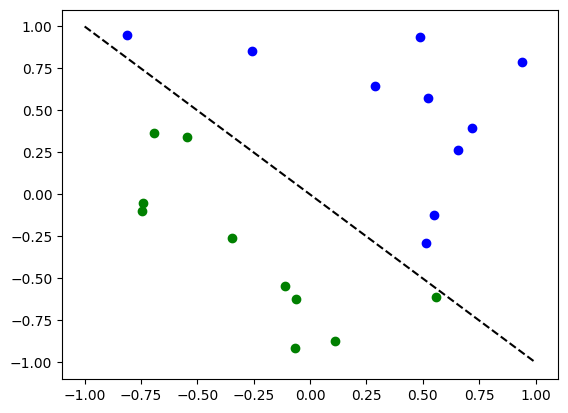

In [31]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with an `EstimatorQNN`

First we show how an `EstimatorQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `EstimatorQNN` is expected to return one-dimensional output in $[-1, +1]$. This only works for binary classification and we assign the two classes to $\{-1, +1\}$. To simplify the composition of parameterized quantum circuit from a feature map and an ansatz we can use the `QNNCircuit` class. 

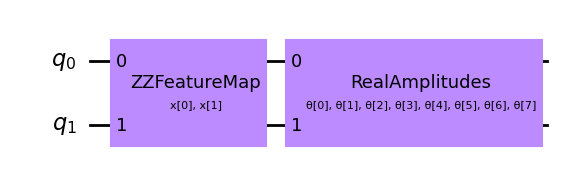

In [32]:
# construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.
qc = QNNCircuit(num_qubits=2)
qc.draw(output="mpl")

Create a quantum neural network

In [33]:
estimator_qnn = EstimatorQNN(circuit=qc)

In [34]:
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.23521988]])

We will add a callback function called `callback_graph`. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [35]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [36]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

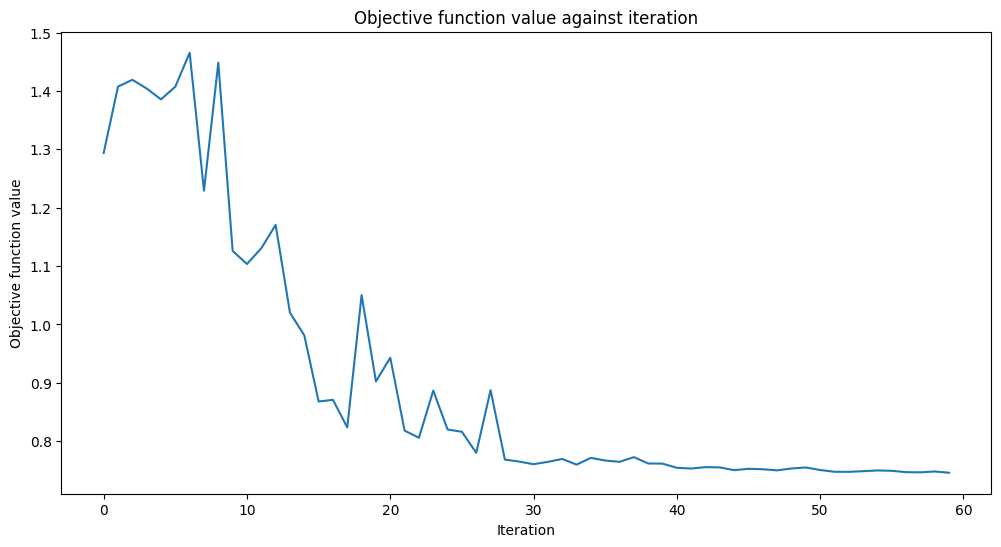

0.8

In [37]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

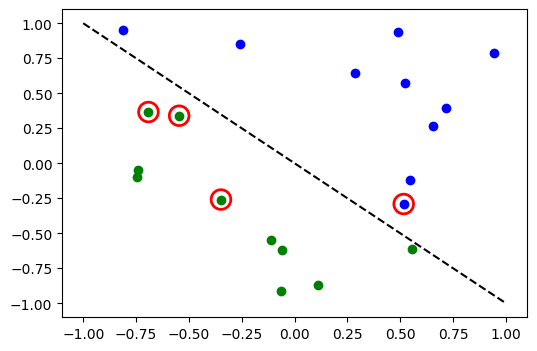

In [38]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Now, when the model is trained, we can explore the weights of the neural network. Please note, the number of weights is defined by ansatz.

In [39]:
estimator_classifier.weights

array([ 0.86209107, -1.06526254, -0.10663602, -0.39086371,  1.0894299 ,
        0.59368219,  2.22731471, -1.04769663])

### Do it yourself

There are a number of ways you can play with the above "model" QNN. First start with the `optimizer`.  This interface is based on [SciPy’s optimize module](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.Minimizer.html#qiskit.algorithms.optimizers.Minimizer). Try different optimizers, do you see any difference?  

In [ ]:
# Code me

### Classification with a `SamplerQNN`

Next we show how a `SamplerQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `SamplerQNN` is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. 
The underlying `Sampler` primitive returns quasi-distributions of bit strings and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping. Again we can use the `QNNCircuit` class to set up a parameterized quantum circuit from a feature map and ansatz of our choice.

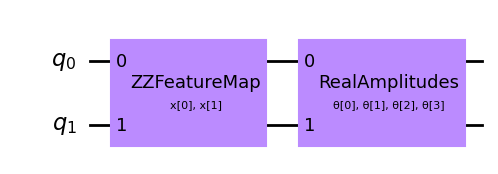

In [40]:
# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw(output="mpl")

In [41]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [42]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

In [43]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

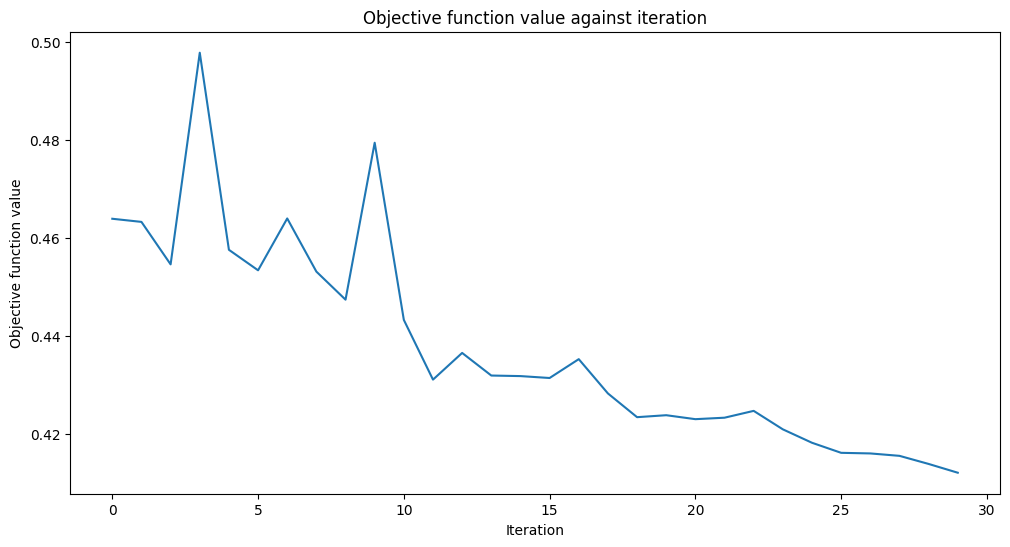

0.7

In [44]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

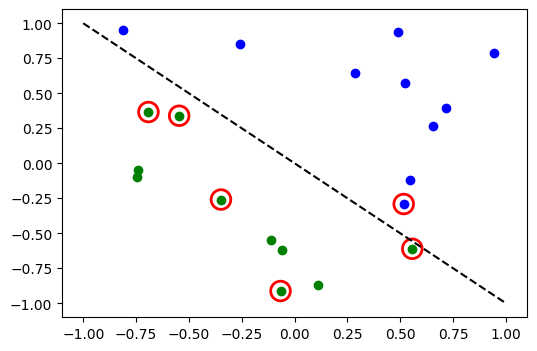

In [45]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Again, once the model is trained we can take a look at the weights. As we set `reps=1` explicitly in our ansatz, we can see less parameters than in the previous model.

In [46]:
sampler_classifier.weights

array([ 1.67198565,  0.46045402, -0.93462862, -0.95266092])

### Variational Quantum Classifier (`VQC`)

The `VQC` is a special variant of the `NeuralNetworkClassifier` with a `SamplerQNN`. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification, which results in a probability vector, which is interpreted as a one-hot encoded result. By default, it applies this the `CrossEntropyLoss` function that expects labels given in one-hot encoded format and will return predictions in that format too.

In [47]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

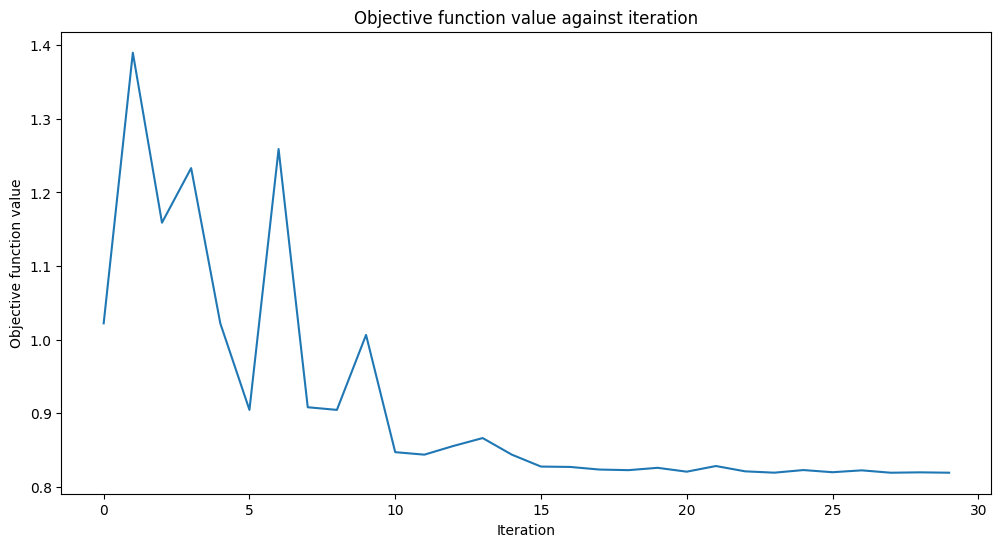

0.75

In [48]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

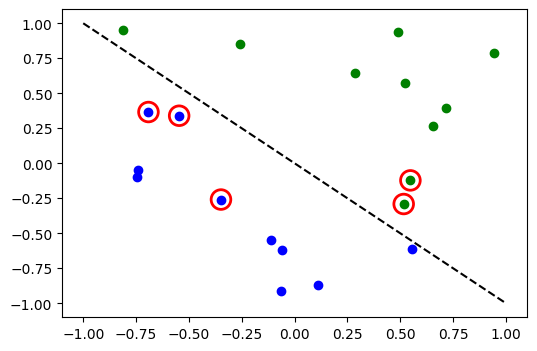

In [49]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Multiple classes with VQC
In this section we generate an artificial dataset that contains samples of three classes and show how to train a model to classify this dataset. This example shows how to tackle more interesting problems in machine learning. Of course, for a sake of short training time we prepare a tiny dataset. We employ `make_classification` from SciKit-Learn to generate a dataset. There 10 samples in the dataset, 2 features, that means we can still have a nice plot of the dataset, as well as no redundant features, these are features are generated as a combinations of the other features. Also, we have 3 different classes in the dataset, each classes one kind of centroid and we set class separation to `2.0`, a slight increase from the default value of `1.0` to ease the classification problem.

Once the dataset is generated we scale the features into the range `[0, 1]`.

In [50]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)
X = MinMaxScaler().fit_transform(X)

Let's see how our dataset looks like.

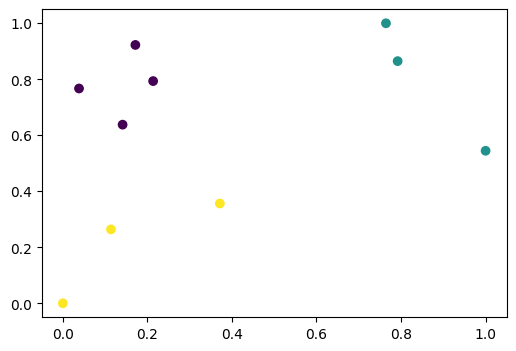

In [51]:
plt.scatter(X[:, 0], X[:, 1], c=y)

We also transform labels and make them categorical.

In [52]:
y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"
print(y_cat)

['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


We create an instance of `VQC` similar to the previous example, but in this case we pass a minimal set of parameters. Instead of feature map and ansatz we pass just the number of qubits that is equal to the number of features in the dataset, an optimizer with a low number of iteration to reduce training time, a quantum instance, and a callback to observe progress.

In [53]:
vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

Start the training process in the same way as in previous examples.

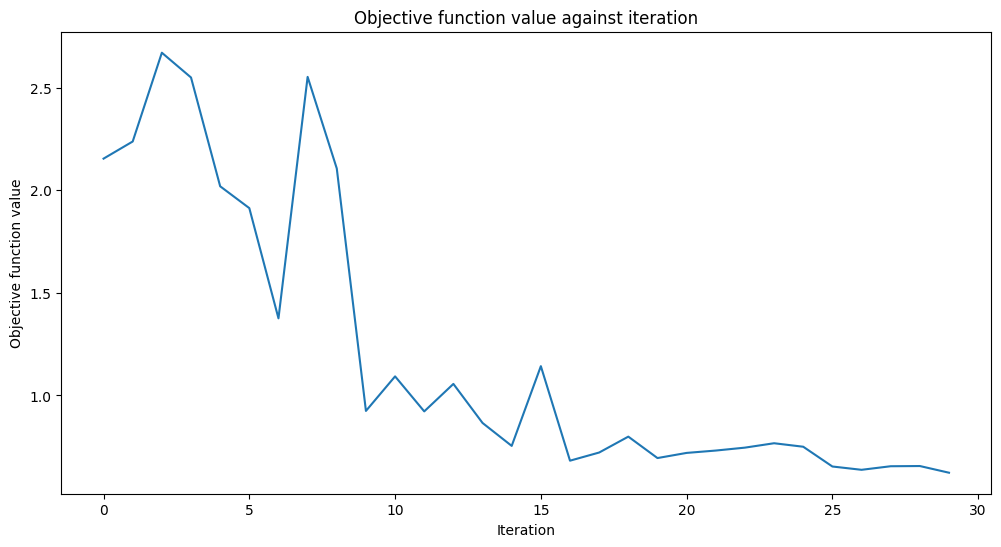

0.9

In [54]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_cat)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_cat)

Despite we had the low number of iterations, we achieved quite a good score. Let see the output of the `predict` method and compare the output with the ground truth.

In [55]:
predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")

Predicted labels: ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'B']
Ground truth:     ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


## Regression

We prepare a simple regression dataset to illustrate the following algorithms.

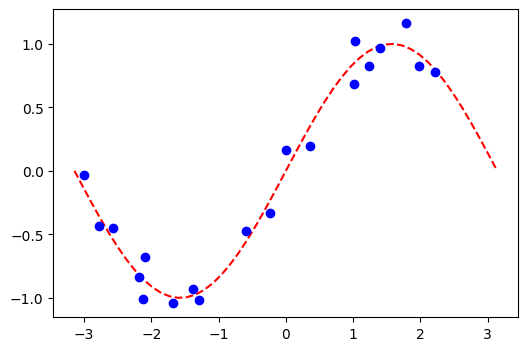

In [56]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

### Regression with an `EstimatorQNN`

Here we restrict to regression with an `EstimatorQNN` that returns values in $[-1, +1]$. More complex and also multi-dimensional models could be constructed, also based on `SamplerQNN` but that exceeds the scope of this tutorial.

In [57]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# construct QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc)

In [58]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

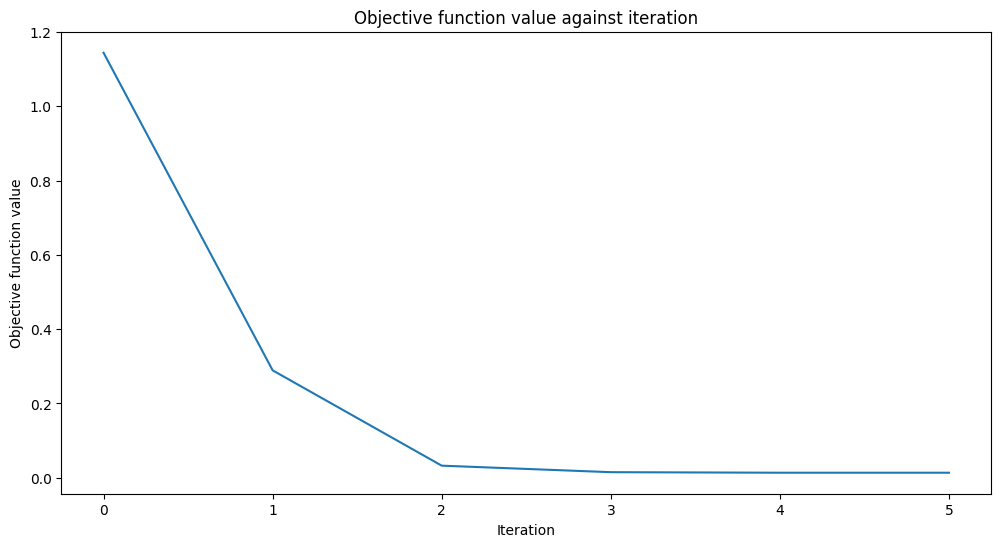

0.9769994291935522

In [59]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

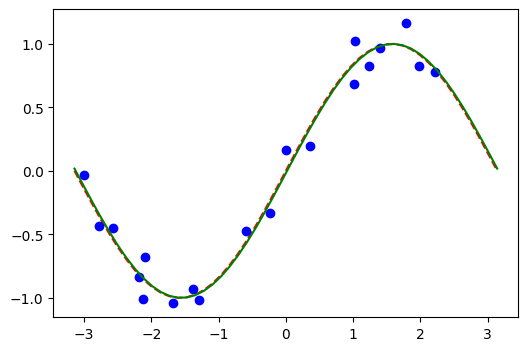

In [60]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

Similarly to the classification models, we can obtain an array of trained weights by querying a corresponding property of the model. In this model we have only one parameter defined as `param_y` above.

In [61]:
regressor.weights

array([-1.58870599])

### Regression with the Variational Quantum Regressor (`VQR`)

Similar to the `VQC` for classification, the `VQR` is a special variant of the `NeuralNetworkRegressor` with a `EstimatorQNN`. By default it considers the `L2Loss` function to minimize the mean squared error between predictions and targets.

In [62]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

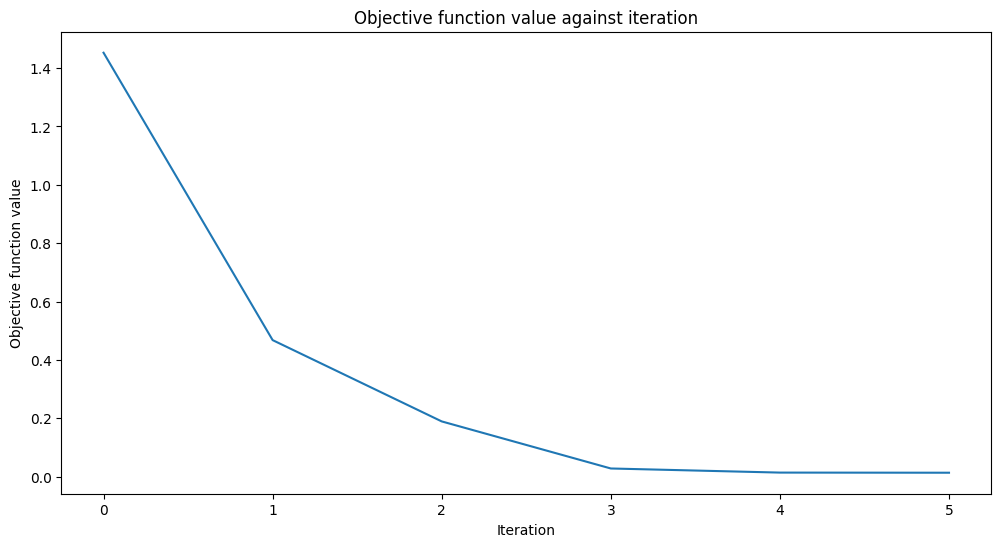

0.9769955693935384

In [63]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

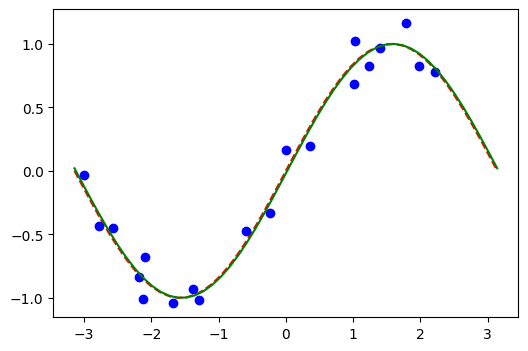

In [64]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

# Barren Plateus (do it yourself)
We've seen that training with gradients works well on the small example model. But can we expect the same if we increase the number of qubits? To investigate that, we measure the variance (A measure of how much a variable deviates from the mean.) of the gradients for different model sizes. The idea is simple: if the variance is really small, we don't have enough information to update our parameters. You'll see that as the number of QNN layers increase, you'll have exponentially vanishing gradients (barren plateaus). This means our gradients contain less and less information and we'll have a hard time to train the model. This is where the loss landscape becomes increasingly flat (and thus hard to determine the direction to the minimum). This issue is discussed in detail in these two references: Jarrod R. McClean, Sergio Boixo, Vadim N. Smelyanskiy, Ryan Babbush and Hartmut Neven, Barren plateaus in quantum neural network training landscapes, Nature Communications, Volume 9, 4812 (2018), doi:10.1038/s41467-018-07090-4, arXiv:1803.11173 and M. Cerezo, Akira Sone, Tyler Volkoff, Lukasz Cincio and Patrick J. Coles, Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits, Nature Communications 12, 1791 (2021), doi:10.1038/s41467-021-21728-w, arXiv:2001.00550. 

Create a neural network for either a regression or classification problem that varies between 2 to 12 layers, and plot variance to observe the barren plateau problem. 



In [ ]:
#Code me


To help us visualize the problem and get a sense of what is happening in the cost landscape let’s look at two circuits with 50 layers each and containing 4 and 12 qubits. We will use the circuit shown below consisting of only 2 parameters $\theta$ and $\phi$. We use the observable ZZ on the first two qubits and visualize the landscape for different values of $\theta$ and $\phi$.

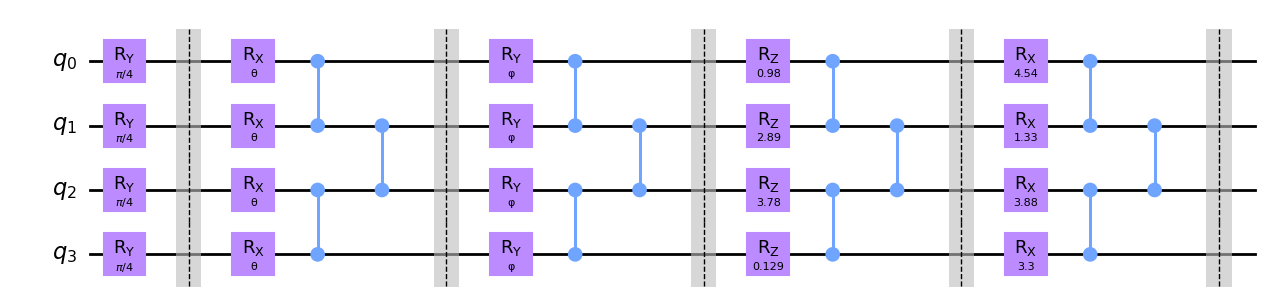

In [65]:


from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit_qulacs.qulacs_estimator import QulacsEstimator
import os

seed = 42
np.random.seed(seed)



estimator = QulacsEstimator()

def generate_random_pqc(n_qubits, n_layers):

    qc = QuantumCircuit(n_qubits)

    theta, phi = Parameter('θ'), Parameter('φ')

    for q in range(n_qubits):
        qc.ry(np.pi / 4, q)

    qc.barrier()

    for l in range(n_layers):

        for q in range(n_qubits):

            if l == 0:
                val = theta
            elif l == 1:
                val = phi
            else:
                val = np.random.uniform(0, 2 * np.pi)

            num = np.random.randint(3)

            if l % 3 == 0:
                qc.rx(val, q)
            elif l % 3 == 1:
                qc.ry(val, q)
            else:
                qc.rz(val, q)

        for q in range(0, n_qubits - 1, 2):
            qc.cz(q, q + 1)
        for q in range(1, n_qubits - 1, 2):
            qc.cz(q, q + 1)

        qc.barrier()

    return qc


circ = generate_random_pqc(4, 4)
circ.draw('mpl')



In [66]:


def generate_surface(circuit, observable):
    Z = []
    Z_assembler = []

    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    for x in X[0, :]:
        for y in Y[:, 0]:
            rotations = np.array([x, y])
            Z_assembler.append(
                estimator.run(circuit, observable,
                              rotations).result().values[0])
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z


def plot_surface(surface):
    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X,
                           Y,
                           surface,
                           rstride=1,
                           cstride=1,
                           cmap=plt.get_cmap('rainbow'),
                           linewidth=0,
                           antialiased=False,
                           alpha=0.6)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('θ')
    ax.set_ylabel('φ')
    ax.set_zlabel('Pauli-Z Expectation')
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()



'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 

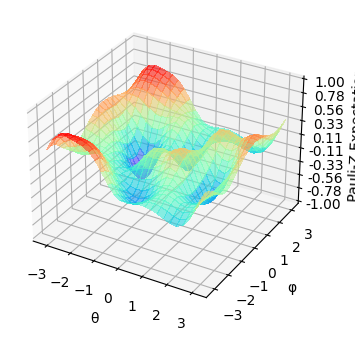

In [67]:
n_qubits = 4
n_layers = 50
op = SparsePauliOp(['I' * (n_qubits - 2) + 'ZZ'])

small_qubit_qc = generate_random_pqc(n_qubits, n_layers)

small_global_surface = generate_surface(small_qubit_qc, op)
plot_surface(small_global_surface)

'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 'to_matrix'
'Barrier' object has no attribute 

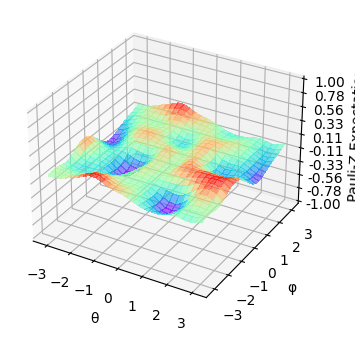

In [68]:


n_qubits = 12
n_layers = 50
op = SparsePauliOp(['I' * (n_qubits - 2) + 'ZZ'])

large_qubit_qc = generate_random_pqc(n_qubits, n_layers)

large_global_surface = generate_surface(large_qubit_qc, op)
plot_surface(large_global_surface)



![](barren1.gif)
![](barren2.gif)
For a 4-qubit circuit, the cost landscape is trainable. However, For a 12-qubit circuit, much of the cost landscape is flattening and becomes difficult to train. This effect will worsen as the number of qubits and layers increases.

## Is there something we can do about these barren plateaus? 

It's a hot topic in current research and there are some proposals to mitigate barren plateaus. First look at how global and local cost functions and the depth of the ansatz influences the barren plateaus. Investigate single layer circuits with various depth using global operators (An operator acting on the entire circuit.) and with local operators. Can you find a scenario without barren plateu? Is it an easy to simulate circuit?

In [ ]:
#Code me

## Layerwise Learning

The Layerwise learning algorithm proposed by Skolik, A., McClean, J.R., Mohseni, M. et al. Layerwise learning for quantum neural networks. Quantum Mach. Intell. 3, 5 (2021). https://doi.org/10.1007/s42484-020-00036-4 is one of the many attempts to tackle Barren Plateu problem. The traditional way we have seen up until now is called complete depth learning (CDL) where all parameters are trained together. However, in a noisy environment, a single unfavourable update can affect the entire circuit and can trap it within a barren plateau. In layerwise learning, the circuit is trained in two phases:

** Phase I **

In the initial phase of the algorithm, we build the ansatz by progressively adding. We first have a circuit with s number of layers whose parameters are initialized to zeros. We train this circuit for a fixed number of epochs, after which we add another set of layers and freeze the parameters of the previous layers. The parameters to optimize are dependent on two hyperparameters p and q. The value of p governs the number of layers added in each step, while q determines the layer interval after which the parameters of prior layers are frozen. For instance, with p = 2 and q = 4, two layers are appended in each step, and layers preceding the current one by more than four are frozen.

** Phase II ** 

The second phase of the algorithm involves further training of the pre-trained circuit from phase I. Here, larger contiguous partitions of layers are trained simultaneously. A hyperparameter r is introduced to specify the percentage of parameters trained within a single step. We train each partition alternatively until convergence. This way we are training on a larger partition (compared to phase I) at once. By constraining randomness to shallower sub-circuits throughout the entire training process, the algorithm also effectively reduces the likelihood of encountering barren plateaus, which could arise due to stochastic or hardware noise present during the sampling procedure.

The following example implementation from [Layerwise learning for Quantum Neural Networks with Qiskit and PyTorch](https://github.com/Gopal-Dahale/ILearnQuantum/tree/main/layerwise_learning_with_qiskit_and_pytorch#layerwise-learning-for-quantum-neural-networks-with-qiskit-and-pytorch) Is rather large, and better run in a PC with GPU. 

In [71]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
import qiskit_algorithms
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch import manual_seed


from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from time import time
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

seed = 42
algorithm_globals.random_seed = seed
np.random.seed(seed)
manual_seed(seed)

sns.set_style("whitegrid")

### Configuration


In [72]:
batch_size = 16
num_workers = 2
n_train_samples = 200
n_test_samples = 2000
n_components = 8

n_qubits = n_components
n_layer_steps = 8
n_layers_to_add = 2
n_layers_to_train = 2
partition_percentage = 0.5
n_sweeps = 2



In [73]:
def min_max_scaling(x, new_min, new_max):
    x_min, x_max = x.min(), x.max()
    return (x - x_min) / (x_max - x_min) * (new_max - new_min) + new_min


### Dataset

In [74]:
# Train Dataset
# -------------

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(root="./data",
                         train=True,
                         download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_train_samples // 2],
    np.where(X_train.targets == 1)[0][:n_train_samples // 2])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



7.9%

100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


In [75]:
# Test Dataset
# -------------

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(root="./data",
                        train=False,
                        download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_test_samples // 2],
    np.where(X_test.targets == 1)[0][:n_test_samples // 2])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

In [76]:
x_train = np.float32(X_train.data.numpy()) / 255.
y_train = X_train.targets.numpy()

x_test = np.float32(X_test.data.numpy()) / 255.
y_test = X_test.targets.numpy()

x_train, y_train = shuffle(x_train, y_train, random_state=seed)
x_test, y_test = shuffle(x_test, y_test, random_state=seed)

x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

pca = PCA(n_components)

x_train = pca.fit_transform(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

x_test = pca.transform(x_test)
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

x_train = min_max_scaling(x_train, 0, 2 * np.pi)
x_test = min_max_scaling(x_test, 0, 2 * np.pi)


Cumulative sum on train : 69.22405
Cumulative sum on train : 69.22405


In [77]:
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset,
                              shuffle=True,
                              batch_size=batch_size,
                              num_workers=num_workers)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset,
                             shuffle=True,
                             batch_size=batch_size,
                             num_workers=num_workers)

In [78]:
feature_map = TwoLocal(n_qubits, ['rx'],
                       parameter_prefix='x',
                       skip_final_rotation_layer=True,
                       reps=1).decompose()

ansatz = TwoLocal(n_qubits, ['ry', 'rz'],
                  'cz',
                  skip_final_rotation_layer=True,
                  entanglement='linear',
                  reps=1).decompose()

input_params = feature_map.parameters
weight_params = ansatz.parameters



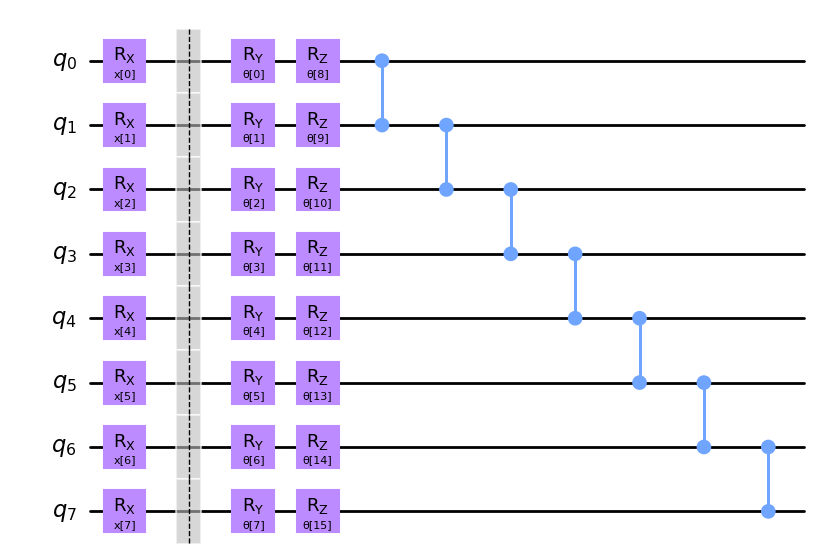

In [79]:
temp_qc = feature_map.copy()
temp_qc.barrier()
temp_qc.compose(ansatz, inplace=True)
temp_qc.draw('mpl')

In [80]:
class Net(torch.nn.Module):
    """Feedfoward neural network with 1 hidden layer"""

    def __init__(self, qnn, **kwargs):
        super().__init__()
        self.qnn = TorchConnector(qnn, **kwargs)
        self.loss_func = torch.nn.BCELoss()

    def forward(self, x):
        # Rescale output to lie between 0 and 1 instead of −1 and 1
        return torch.clamp((self.qnn(x) + 1) / 2, min=0.0, max=1.0)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = self.loss_func(out, labels.view(-1, 1))  # Calculate loss
        return loss


### Phase 1

In [ ]:
from qiskit_algorithms.gradients import ReverseEstimatorGradient

num_weights = len(weight_params)

# We use qiskit-qulacs to run qiskit circuits on qulacs backend
# This speeds up the training process

estimator = Estimator()
gradient = ReverseEstimatorGradient(estimator)

n_qubits = ansatz.num_qubits
main_qc = QuantumCircuit(n_qubits)

assert feature_map.num_qubits == ansatz.num_qubits
main_qc.compose(feature_map, range(n_qubits), inplace=True)

residual_qc = main_qc.copy()  # used in Phase II

layer_params = []  # stores the parameters of layers
layer_param_values = []  # stores the corresponding parameter values

losses = []

s = time()

for layer_id in range(n_layer_steps):
    print("\nLayer:", layer_id)

    qc = QuantumCircuit(n_qubits)
    temp_params = []

    # Append layers
    for i in range(n_layers_to_add):
        params = ParameterVector(f"θ_{layer_id}_{i}", num_weights)
        qc.compose(
            ansatz.assign_parameters(dict(zip(weight_params, params))),
            range(n_qubits),
            inplace=True,
        )
        temp_params.append(params)

    # Parameter and its values for current layer
    # we perform a small deviation from all zeros
    temp_params = np.asarray(temp_params).flatten()
    temp_init = np.zeros(temp_params.shape) + 0.001

    main_qc.compose(qc, range(n_qubits), inplace=True)
    residual_qc.compose(qc, range(n_qubits), inplace=True)
    residual_qc.barrier()

    layer_params.append(temp_params)

    # Freeze all parameters before `n_layers_to_train`
    # To perform the freezing, we bind the parameter values
    # and keep only the trainable parameters for `n_layers_to_train` layers
    if layer_id >= n_layers_to_train:
        freeze_params = layer_params[-n_layers_to_train - 1]
        index = num_weights * n_layers_to_add * (n_layers_to_train - 1)
        freeze_param_values = layer_param_values[-index - num_weights *
                                                 n_layers_to_add:-index]
        main_qc = main_qc.bind_parameters(
            dict(zip(freeze_params, freeze_param_values)))
        initial_point = np.concatenate(
            (layer_param_values[-index:], temp_init))
        initial_params = np.asarray(
            layer_params[-n_layers_to_train:]).flatten()
    else:
        initial_point = np.concatenate((layer_param_values, temp_init))
        initial_params = np.asarray(layer_params).flatten()

    qnn = EstimatorQNN(
        estimator=estimator,
        circuit=main_qc,
        input_params=input_params,
        weight_params=initial_params,
        gradient=gradient,
        input_gradients=False,
    )

    # Model and Training
    model = Net(qnn, initial_weights=initial_point)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    epochs = 20  # Set number of epochs
    loss_list = []  # Store loss history
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss.append(loss.item())  # Store loss
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(
            100.0 * (epoch + 1) / epochs, loss_list[-1]))

    losses.append(loss_list)

    # Extract the current weights and store them
    with torch.no_grad():
        weights = [param for param in model.parameters()][0].numpy()

    if layer_id >= n_layers_to_train:
        layer_param_values = np.concatenate((layer_param_values, temp_init))
        index = num_weights * n_layers_to_add * n_layers_to_train
        layer_param_values[-index:] = weights.copy()
    else:
        layer_param_values = weights.copy()

e = time()
print("\nDuration {:.4f} s".format(e - s))



In [ ]:
# Plot loss convergence
plt.plot(np.array(losses).flatten())
plt.title("Phase I Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Binary Cross Entropy Loss")
plt.show()

In [ ]:
residual_qc.draw('mpl')

### Phase 2 

In [ ]:
qc = residual_qc.copy()

# Number of weights in the first partition
n_p1_weights = int(len(layer_param_values) * partition_percentage)

# Partition 1 weights
p1_weights = dict(
    zip(
        np.asarray(layer_params).flatten()[:n_p1_weights],
        layer_param_values[:n_p1_weights],
    ))

# Partition 2 weights
p2_weights = dict(
    zip(
        np.asarray(layer_params).flatten()[n_p1_weights:],
        layer_param_values[n_p1_weights:],
    ))

losses2 = []

s = time()

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
    # configure and train first partition
    print("\nSweep {}, partition 1\n".format(sweep))

    # Freeze the partition 2 weights
    train_qc = qc.bind_parameters(p2_weights)

    # Train only partition 1 weights
    qnn = EstimatorQNN(
        estimator=estimator,
        circuit=train_qc,
        input_params=input_params,
        weight_params=list(p1_weights.keys()),
        gradient=gradient,
        input_gradients=True,
    )

    model = Net(qnn, initial_weights=list(p1_weights.values()))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    epochs = 20  # Set number of epochs
    loss_list = []  # Store loss history
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss.append(loss.item())  # Store loss
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(
            100.0 * (epoch + 1) / epochs, loss_list[-1]))

    losses.append(loss_list)

    with torch.no_grad():
        trained_weights = [param for param in model.parameters()][0].numpy()

    p1_weights = {
        key: value
        for key, value in zip(p1_weights.keys(), trained_weights)
    }

    # configure and train second partition
    print("\nSweep {}, partition 2\n".format(sweep))

    # Freeze the partition 1 weights
    train_qc = qc.bind_parameters(p1_weights)

    # Train only partition 2 weights
    qnn = EstimatorQNN(
        estimator=estimator,
        circuit=train_qc,
        input_params=input_params,
        weight_params=list(p2_weights.keys()),
        gradient=gradient,
        input_gradients=True,
    )

    model = Net(qnn, initial_weights=list(p2_weights.values()))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    epochs = 20  # Set number of epochs
    loss_list = []  # Store loss history
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss.append(loss.item())  # Store loss
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(
            100.0 * (epoch + 1) / epochs, loss_list[-1]))

    losses2.append(loss_list)

    with torch.no_grad():
        trained_weights = [param for param in model.parameters()][0].numpy()

    p2_weights = {
        key: value
        for key, value in zip(p2_weights.keys(), trained_weights)
    }

e = time()

print("\nDuration {:.4f} s".format(e - s))

In [ ]:
# Plot loss convergence
plt.plot(np.array(losses2).flatten())
plt.title("Phase II Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Binary Cross Entropy Loss")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(np.array(losses).flatten())
ax[0].set_xlabel("Training Iterations")
ax[0].set_ylabel("Binary Cross Entropy Loss")
ax[0].set_title("Phase I Training Convergence")

ax[1].plot(np.array(losses2).flatten())
ax[1].set_xlabel("Training Iterations")
ax[1].set_ylabel("Binary Cross Entropy Loss")
ax[1].set_title("Phase II Training Convergence")

In [ ]:
def accuracy(outputs, labels):
    preds = outputs > 0.5
    return torch.tensor(
        torch.sum(preds == labels.view(-1, 1)).item() / len(preds))


def evaluate(model, loader):
    batch_accs = [accuracy(model(images), labels) for images, labels in loader]
    return torch.stack(batch_accs).mean().item()

In [ ]:
predictions = []
targets = []

model.eval()
train_acc = evaluate(model, train_dataloader)
test_acc = evaluate(model, test_dataloader)

train_acc, test_acc

# Training a Quantum Model on a Real Dataset

This tutorial will demonstrate how to train a quantum machine learning model to tackle a classification problem. Previous tutorials have featured small, artificial datasets. Here we will increase the problem complexity by considering a real-life classical dataset. We decided to pick a very well-known – albeit still relatively small – problem: the Iris flower dataset. This dataset even has its own Wikipedia [page](https://en.wikipedia.org/wiki/Iris_flower_data_set). Although the Iris dataset is well known to data scientists, we will briefly introduce it to refresh our memories. For comparison, we'll first train a classical counterpart to the quantum model.

So, let's get started:

- First, we'll load the dataset and explore what it looks like.
- Next, we'll train a classical model using [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from [scikit-learn](https://scikit-learn.org/) to see how well the classification problem can be solved using classical methods.
- After that, we'll introduce the Variational Quantum Classifier (VQC).
- To conclude, we'll compare the results obtained from both models.

## 1. Exploratory Data Analysis

First, let us explore the Iris dataset this tutorial will use and see what it contains. For our convenience, this [dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset) is available in scikit-learn and can be loaded easily.

In [66]:
from sklearn.datasets import load_iris

iris_data = load_iris()

If no parameters are specified in the `load_iris` function, then a dictionary-like object is returned by scikit-learn. Let's print the description of the dataset and see what is inside.

In [67]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

There are a few interesting observations we can find from this dataset description:

- There are 150 samples (instances) in the dataset.
- There are four features (attributes) in each sample.
- There are three labels (classes) in the dataset.
- The dataset is perfectly balanced, as there are the same number of samples (50) in each class.
- We can see features are not normalized, and their value ranges are different, e.g., $[4.3, 7.9]$ and $[0.1, 2.5]$ for sepal length and petal width, respectively. So, transforming the features to the same scale may be helpful.
- As stated in the table above, feature-to-class correlation in some cases is very high; this may lead us to think that our model should cope well with the dataset.

We only examined the dataset description, but additional properties are available in the `iris_data` object. Now we are going to work with features and labels from the dataset.

In [68]:
features = iris_data.data
labels = iris_data.target

Firstly, we'll normalize the features. Namely, we will apply a simple transformation to represent all features on the same scale. In our case, we squeeze all features onto the interval $[0, 1]$. Normalization is a common technique in machine learning and often leads to better numerical stability and convergence of an algorithm.

We can use `MinMaxScaler` from scikit-learn to perform this. Without specifying parameters, this does exactly what is required: maps data onto $[0, 1]$.

In [69]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Let's see how our data looks. We plot the features pair-wise to see if there's an observable correlation between them.

/home/obm/miniconda3/envs/phys710/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


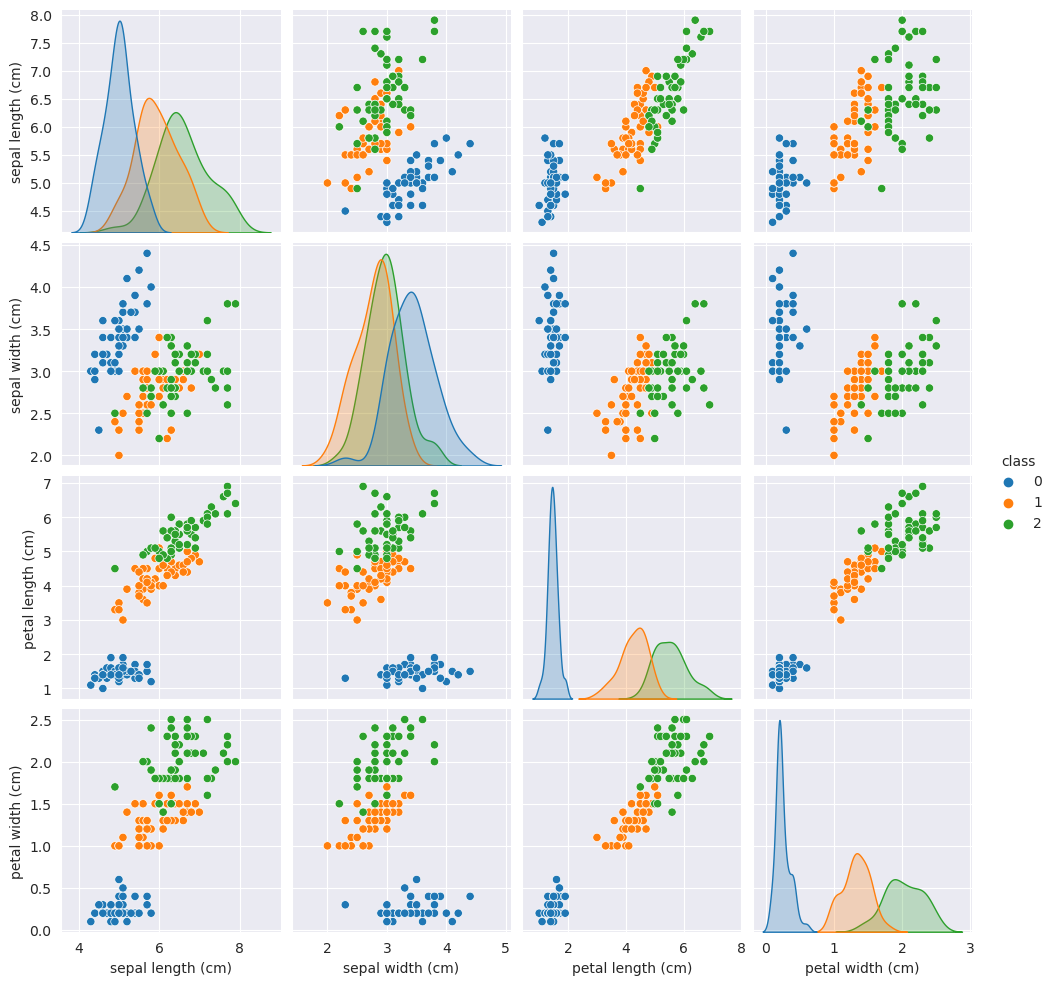

In [70]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

From the plots, we see that class `0` is easily separable from the other two classes, while classes `1` and `2` are sometimes intertwined, especially regarding the "sepal width" feature.

Next, let's see how classical machine learning handles this dataset. 

## 2. Training a Classical Machine Learning Model

Before we train a model, we should split the dataset into two parts: a training dataset and a test dataset. We'll use the former to train the model and the latter to verify how well our models perform on unseen data.

As usual, we'll ask scikit-learn to do the boring job for us. We'll also fix the seed to ensure the results are reproducible.

In [71]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

We train a classical Support Vector Classifier from scikit-learn. For the sake of simplicity, we don't tweak any parameters and rely on the default values.

In [72]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

Now we check out how well our classical model performs. We will analyze the scores in the conclusion section.

In [73]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


As can be seen from the scores, the classical SVC algorithm performs very well. Next up, it's time to look at quantum machine learning models.

## 3. Training a Quantum Machine Learning Model

As an example of a quantum model, we'll train a variational quantum classifier (VQC). The VQC is the simplest classifier available in Qiskit Machine Learning and is a good starting point for newcomers to quantum machine learning who have a background in classical machine learning.

But before we train a model, let's examine what comprises the `VQC` class. Two of its central elements are the feature map and ansatz. What these are will now be explained.

Our data is classical, meaning it consists of a set of bits, not qubits. We need a way to encode the data as qubits. This process is crucial if we want to obtain an effective quantum model. We usually refer to this mapping as data encoding, data embedding, or data loading and this is the role of the feature map. While feature mapping is a common ML mechanism, this process of loading data into quantum states does not appear in classical machine learning as that only operates in the classical world.

Once the data is loaded, we must immediately apply a parameterized quantum circuit. This circuit is a direct analog to the layers in classical neural networks. It has a set of tunable parameters or weights. The weights are optimized such that they minimize an objective function. This objective function characterizes the distance between the predictions and known labeled data. A parameterized quantum circuit is also called a parameterized trial state, variational form, or ansatz. Perhaps, the latter is the most widely used term.

For more information, we direct the reader to the [Quantum Machine Learning Course](https://learn.qiskit.org/course/machine-learning).

Our choice of feature map will be the ``ZZFeatureMap``. The ``ZZFeatureMap`` is one of the standard feature maps in the Qiskit circuit library. We pass `num_features` as `feature_dimension`, meaning the feature map will have `num_features` or `4` qubits.

We decompose the feature map into its constituent gates to give the reader a flavor of how feature maps may look.

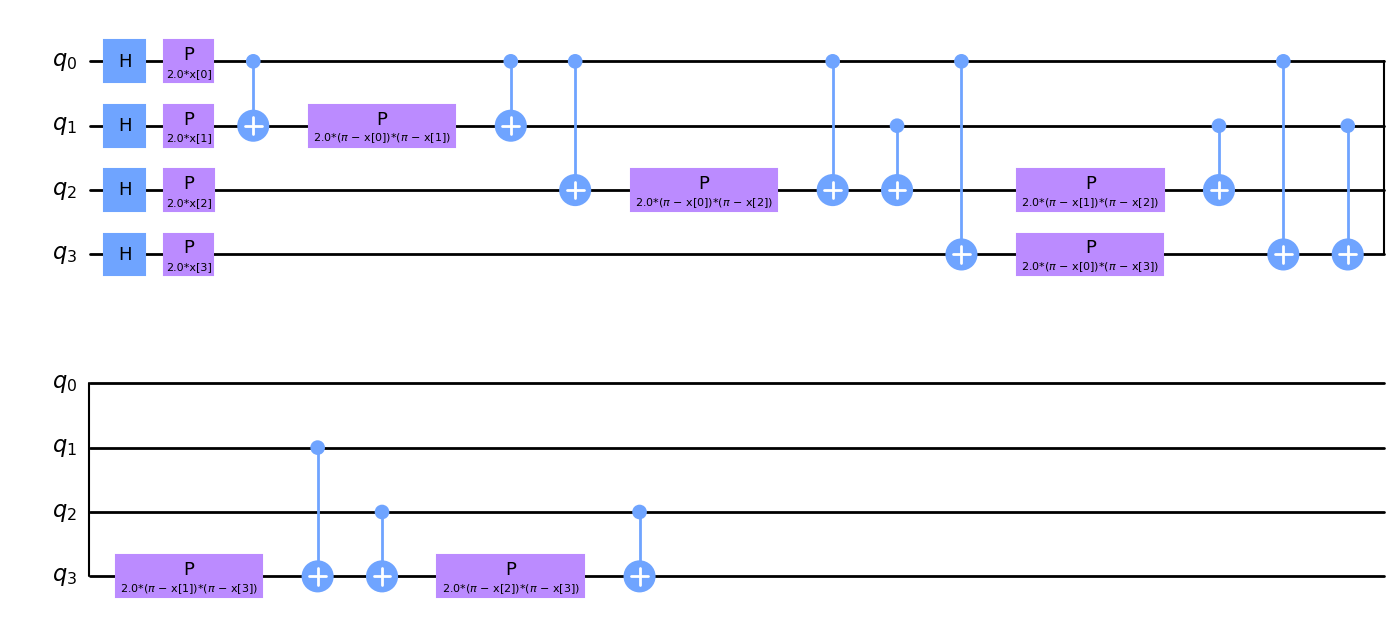

In [74]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

If you look closely at the feature map diagram, you will notice parameters `x[0], ..., x[3]`. These are placeholders for our features.

Now we create and plot our ansatz. Pay attention to the repetitive structure of the ansatz circuit. We define the number of these repetitions using the `reps` parameter.

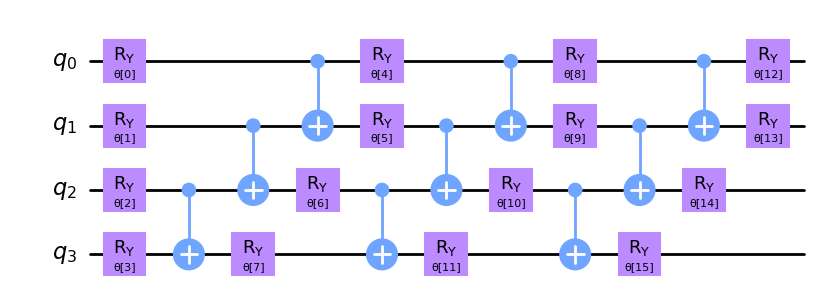

In [75]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

This circuit has 16 parameters named `θ[0], ..., θ[15]`. These are the trainable weights of the classifier.

We then choose an optimization algorithm to use in the training process. This step is similar to what you may find in classical deep learning frameworks. To make the training process faster, we choose a gradient-free optimizer. You may explore other optimizers available in Qiskit.

In [76]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In the next step, we define where to train our classifier. We can train on a simulator or a real quantum computer. Here, we will use a simulator. We create an instance of the `Sampler` primitive. This is the reference implementation that is statevector based. Using qiskit runtime services you can create a sampler that is backed by a quantum computer.

In [77]:
from qiskit.primitives import Sampler

sampler = Sampler()

We will add a callback function called `callback_graph`. `VQC` will call this function for each evaluation of the objective function with two parameters: the current weights and the value of the objective function at those weights. Our callback will append the value of the objective function to an array so we can plot the iteration versus the objective function value. The callback will update the plot at each iteration. Note that you can do whatever you want inside a callback function, so long as it has the two-parameter signature we mentioned above.

In [78]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we are ready to construct the classifier and fit it. 

`VQC` stands for "variational quantum classifier." It takes a feature map and an ansatz and constructs a quantum neural network automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. You may omit the `sampler` parameter, in this case a `Sampler` instance will be created for you in the way we created it earlier. We created it manually for illustrative purposes only.

Training may take some time. Please, be patient.

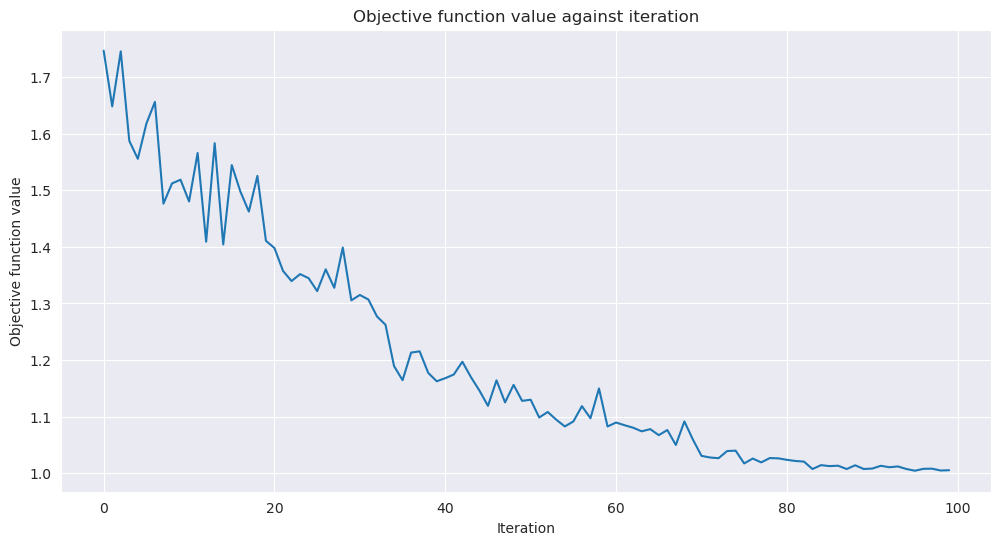

Training time: 152 seconds


In [79]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Let's see how the quantum model performs on the real-life dataset.

In [80]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.85
Quantum VQC on the test dataset:     0.87


As we can see, the scores are high, and the model can be used to predict labels on unseen data.

Now let's see what we can tune to get even better models.

- The key components are the feature map and the ansatz. You can tweak parameters. In our case, you may change the `reps` parameter that specifies how repetitions of a gate pattern we add to the circuit. Larger values lead to more entanglement operations and more parameters. Thus, the model can be more flexible, but the higher number of parameters also adds complexity, and training such a model usually takes more time. Furthermore, we may end up overfitting the model. You can try the other feature maps and ansatzes available in the [Qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits), or you can come up with custom circuits.
- You may try other optimizers. Qiskit contains a bunch of them. Some of them are gradient-free, others not. If you choose a gradient-based optimizer, e.g., `L_BFGS_B`, expect the training time to increase. Additionally to the objective function, these optimizers must evaluate the gradient with respect to the training parameters, which leads to an increased number of circuit executions per iteration.
- Another option is to randomly (or deterministically) sample `initial_point` and fit the model several times.

But what if a dataset contains more features than a modern quantum computer can handle? Recall, in this example, we had the same number of qubits as the number of features in the dataset, but this may not always be the case.

## 4. Reducing the Number of Features

In this section, we reduce the number of features in our dataset and train our models again. We'll move through faster this time as the steps are the same except for the first, where we apply a PCA transformation. 

We transform our four features into two features only. This dimensionality reduction is for educational purposes only. As you saw in the previous section, we can train a quantum model using all four features from the dataset.

Now, we can easily plot these two features on a single figure.

<Axes: >

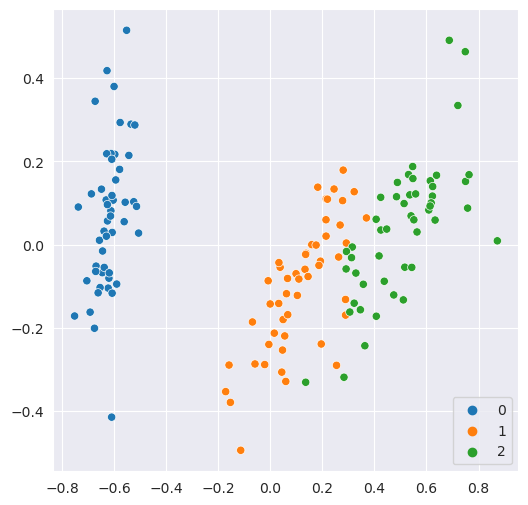

In [81]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

As usual, we split the dataset first, then fit a classical model.

In [82]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


The results are still good but slightly worse compared to the initial version. Let's see how a quantum model deals with them. As we now have two qubits, we must recreate the feature map and ansatz.

In [83]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

We also reduce the maximum number of iterations we run the optimization process for, as we expect it to converge faster because we now have fewer qubits.

In [84]:
optimizer = COBYLA(maxiter=40)

Now we construct a quantum classifier from the new parameters and train it. 

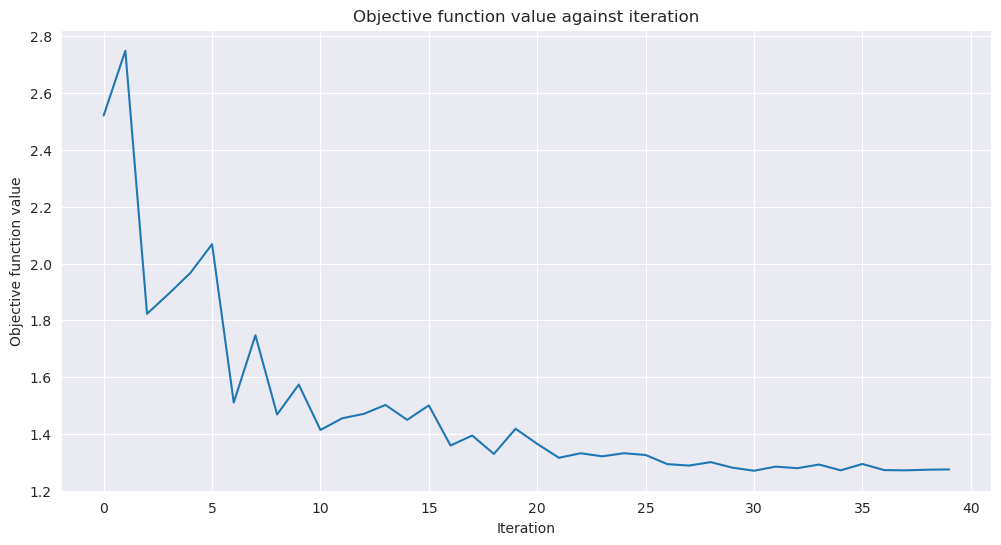

Training time: 46 seconds


In [85]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [86]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.58
Quantum VQC on the test dataset using RealAmplitudes:     0.63


Well, the scores are higher than a fair coin toss but could be better. The objective function is almost flat towards the end, meaning increasing the number of iterations won't help, and model performance will stay the same. Let's see what we can do with another ansatz.

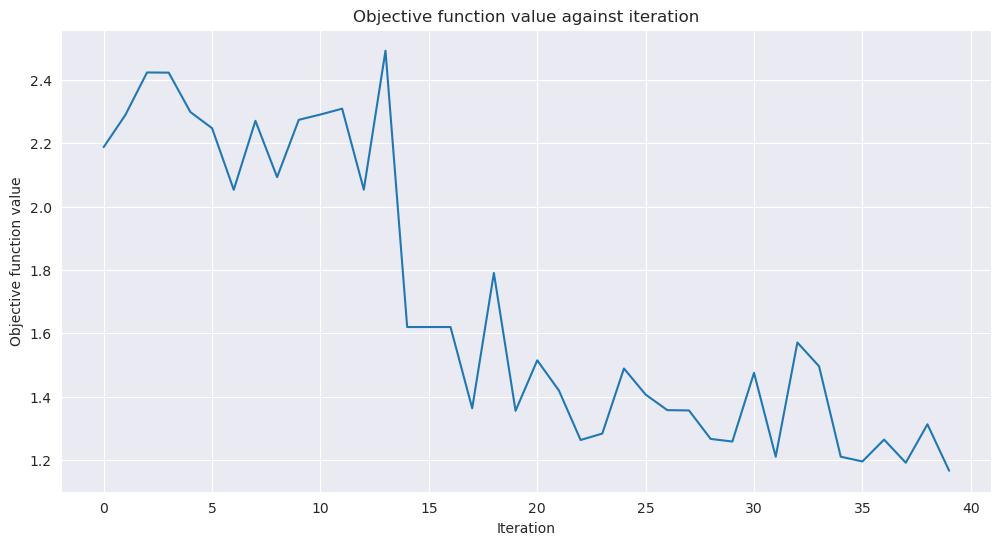

Training time: 60 seconds


In [87]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

The scores are better than in the previous setup. Perhaps if we had used more iterations, we could do even better.

## 5. Conclusion

In this tutorial, we have built two classical and three quantum machine learning models. Let's print an overall table with our results.

In [ ]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")

Unsurprisingly, the classical models perform better than their quantum counterparts, but classical ML has come a long way, and quantum ML has yet to reach that level of maturity. As we can see,  we achieved the best results using a classical support vector machine. But the quantum model trained on four features was also quite good. When we reduced the number of features, the performance of all models went down as expected. So, if resources permit training a model on a full-featured dataset without any reduction, you should train such a model. If not, you may expect to compromise between dataset size, training time, and score.

Another observation is that even a simple ansatz change can lead to better results. The two-feature model with the `EfficientSU2` ansatz performs better than the one with `RealAmplitudes`. That means the choice of hyperparameters plays the same critical role in quantum ML as in classical ML, and searching for optimal hyperparameters may take a long time. You may apply the same techniques we use in classical ML, such as random/grid or more sophisticated approaches.

### Do it after

Scikit learn offers tools for [generated datasets](https://scikit-learn.org/stable/datasets/sample_generators.html). Use VQC and VQR with generated regression and classification datasets in a python script. [Can you use other providers?](https://qiskit.org/providers). Can you implement Layerwise learning?   